In [5]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
import pandas as pd
import numpy as np

from pathlib import Path

In [6]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected.csv")
y_train = pd.read_csv(path / "y_train.csv")

print(X_train.shape)

(1934, 14)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
print(X_train.shape, X_val.shape)

(1547, 14) (387, 14)


In [8]:
RANDOM_STATE = 42
CV_SPLITS = 5
SEARCH_ITER = 10
SCORING = "roc_auc_ovr"  # chosen because we will tune threshold later; could be recall_macro or f1_macro

# Pipeline with forward feature selection + MLP
pipe = Pipeline(
    steps=[
        (
            "feature_selection",
            SequentialFeatureSelector(
                estimator=MLPClassifier(
                    hidden_layer_sizes=(32,),
                    max_iter=100,
                    random_state=RANDOM_STATE,
                ),
                direction="forward",
                n_features_to_select=5,
                scoring=SCORING,
                cv=CV_SPLITS,
                n_jobs=-1,
            ),
        ),
        (
            "mlp",
            MLPClassifier(
                max_iter=100,
                hidden_layer_sizes=(32,),
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)
# Outer CV for Bayes search
cv = StratifiedKFold(
    n_splits=CV_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

layer_configs = [
    (32,),
    (32, 16),
]

scalar_space = {
    "mlp__alpha": Real(1e-5, 1e-1, prior="log-uniform"),
    "mlp__learning_rate_init": Real(1e-4, 1e-1, prior="log-uniform"),
    "mlp__activation": Categorical(["relu"]),
}

best_score = -np.inf
best_params = None
best_layers = None
best_model = None

In [9]:
import warnings

warnings.filterwarnings("ignore")

for layers in layer_configs:
    pipe.set_params(mlp__hidden_layer_sizes=layers)
    print(f"Fitting: {layers}")
    search = BayesSearchCV(
        estimator=pipe,
        search_spaces=scalar_space,
        n_iter=SEARCH_ITER,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1,
        refit=True,
        random_state=RANDOM_STATE,
        verbose=0,
    )
    search.fit(X_train, y_train)

    print(f"Model fited with: ", layers, "Score: ", search.best_score_)

    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_model = search.best_estimator_
        best_layers = layers

Fitting: (32,)
Model fited with:  (32,) Score:  0.9415908256880735
Fitting: (32, 16)
Model fited with:  (32, 16) Score:  0.9431345287739783


In [15]:
print("Best CV mean score:", best_score)
print("Best layers:", best_layers)

# Merge layers into params dict for convenience
best_params_with_layers = {
    **best_params,
    "mlp__hidden_layer_sizes": best_layers,
}
print("Best params (incl. layers):", best_params_with_layers)

Best CV mean score: 0.9431345287739783
Best layers: (32, 16)
Best params (incl. layers): {'mlp__activation': 'relu', 'mlp__alpha': 0.0081452228834028, 'mlp__learning_rate_init': 0.06289324408100383, 'mlp__hidden_layer_sizes': (32, 16)}


In [16]:
sfs = best_model.named_steps["feature_selection"]

selected_mask = sfs.get_support()
selected_features = X_train.columns[selected_mask]

print("Selected features:", list(selected_features))

Selected features: ['cat__BehavioralProblems_0', 'cat__MemoryComplaints_1', 'num__ADL', 'num__FunctionalAssessment', 'num__MMSE']


AUC: 0.9752723948811701


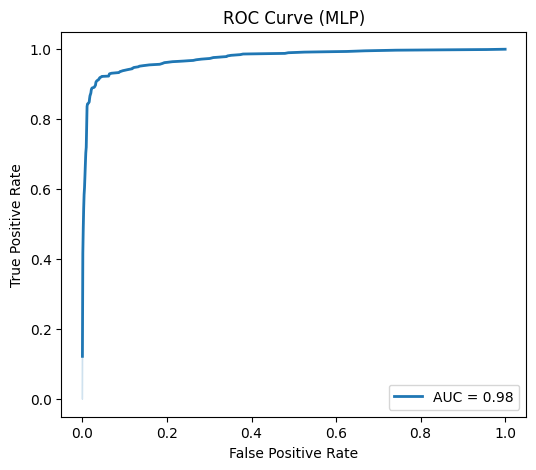

In [17]:
import sys

sys.path.append(".")
sys.path.append("..")

from helpers.roc_utils import plot_roc

auc = plot_roc(best_model, X_train, y_train, title="ROC Curve (MLP)")
print("AUC:", auc)

In [18]:
import pickle

model_path = Path("../data/models")
model_path.mkdir(parents=True, exist_ok=True)

with open(model_path / "MLP_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

## Treshold


In [19]:
import pickle
from pathlib import Path

model_path = Path("../data/models") / "MLP_best_model.pkl"

with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

In [20]:
from sklearn.metrics import fbeta_score
import numpy as np

probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 200)
best_t = None


thresholds = np.linspace(0, 1, 200)
scores = [fbeta_score(y_val, (probs >= t).astype(int), beta=2) for t in thresholds]
best_t = thresholds[np.argmax(scores)]

In [21]:
best_t

np.float64(0.135678391959799)

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np


def evaluate_at_threshold(model, X, y, threshold: float, model_name: str = "Model"):
    """
    Evaluate a probabilistic classifier at a fixed threshold.
    Prints confusion matrix, precision, recall, specificity
    and returns them in a dict.
    """
    # 1. Probabilities & hard predictions
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    # 2. Confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 3. Metrics
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred)  # sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # 4. Print nicely
    print(f"\n=== {model_name} @ threshold = {threshold:.3f} ===")
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm)
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Precision : {precision:.3f}")
    print(f"Recall    : {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")

    return {
        "confusion_matrix": cm,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
    }

In [23]:
path = Path("../data/selected")
X_test = pd.read_csv(path / "X_test_selected.csv")
y_test = pd.read_csv(path / "y_test.csv")

In [24]:
results_svm = evaluate_at_threshold(best_model, X_test, y_test, best_t)
results_svm


=== Model @ threshold = 0.136 ===
Confusion matrix (rows = true, cols = predicted):
[[120  19]
 [  3  73]]
TN: 120, FP: 19, FN: 3, TP: 73
Precision : 0.793
Recall    : 0.961
Specificity: 0.863


{'confusion_matrix': array([[120,  19],
        [  3,  73]]),
 'TN': np.int64(120),
 'FP': np.int64(19),
 'FN': np.int64(3),
 'TP': np.int64(73),
 'precision': 0.7934782608695652,
 'recall': 0.9605263157894737,
 'specificity': np.float64(0.8633093525179856)}